In [1]:
import torch
import time
from rewrite import *
from predict import *
from enhance import *
from datasets import load_dataset
import pickle
from random import sample


In [1]:
import pandas as pd
from datasets import load_dataset

# Load the dataset from Hugging Face
dataset = pd.read_csv('datasets/loan_approval_dataset.csv')

# View the first few rows of the dat

In [2]:
dataset

loan_id   no_of_dependents      education  self_employed   income_annum  \
0           1                  2       Graduate             No        9600000   
1           2                  0   Not Graduate            Yes        4100000   
2           3                  3       Graduate             No        9100000   
3           4                  3       Graduate             No        8200000   
4           5                  5   Not Graduate            Yes        9800000   
...       ...                ...            ...            ...            ...   
4264     4265                  5       Graduate            Yes        1000000   
4265     4266                  0   Not Graduate            Yes        3300000   
4266     4267                  2   Not Graduate             No        6500000   
4267     4268                  1   Not Graduate             No        4100000   
4268     4269                  1       Graduate             No        9200000   

       loan_amount   loan_term   cibil_score   residential_assets_value  \
0         29900000          12           778                    2400000   
1         12200000           8           417                    2700000   
2         29700000          20           506                    7100000   
3         30700000           8           467                   18200000   
4         24200000          20           382                   12400000   
...            ...         ...           ...                        ...   
4264       2300000          12           317                    2800000   
4265      11300000          20           559                    4200000   
4266      23900000          18           457                    1200000   
4267      12800000           8           780                    8200000   
4268      29700000          10           607                   17800000   

       commercial_assets_value   luxury_assets_value   bank_asset_value  \
0                     17600000              22700000            8000000   
1                      2200000               8800000            3300000   
2                      4500000              33300000           12800000   
3                      3300000              23300000            7900000   
4                      8200000              29400000            5000000   
...                        ...                   ...                ...   
4264                    500000               3300000             800000   
4265                   2900000              11000000            1900000   
4266                  12400000              18100000            7300000   
4267                    700000              14100000            5800000   
4268                  11800000              35700000           12000000   

      loan_status  
0        Approved  
1        Rejected  
2        Rejected  
3        Rejected  
4        Rejected  
...           ...  
4264     Rejected  
4265     Approved  
4266     Rejected  
4267     Approved  
4268     Approved  

[4269 rows x 13 columns]

In [3]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score

# Load the dataset
data = dataset  # Replace with the actual dataset path

# Fill NaN values for simplicity
data.fillna("unknown", inplace=True)


In [4]:
import torch
import time
import pickle
from random import sample

In [5]:
from rewrite import create_model
import argparse 

def get_label(model_str, tokenizer, pipe, sent, device):
    '''
    helper for predict function
    '''
    input_text = "Return the correct Loan label on the following people: \"" + sent + "\"Return Approved or Rejected. Answer: "
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    if model_str  == "google/flan-t5-large":
        outputs = pipe.generate(input_ids, max_length=3, early_stopping=True)
        out = tokenizer.decode(outputs[0])
    elif model_str == "google/flan-ul2":
        outputs = pipe.generate(input_ids, max_length=3, early_stopping=True)
        out = tokenizer.decode(outputs[0])
    elif model_str == "llama" or model_str == "llama-13b":
        outputs = pipe.generate(input_ids, temperature=0.1, max_new_tokens=3, early_stopping=True)
        out = tokenizer.decode(outputs[0], skip_special_tokens=True)
    elif model_str == "llama2" or model_str.lower() == "llama2-13b" or model_str.lower() == "llama2-7b":
        outputs = pipe.generate(input_ids, temperature=0.1, top_p = 0.1, max_new_tokens=3, early_stopping=True)
        out = tokenizer.decode(outputs[0], skip_special_tokens=True)
    elif model_str == "vicuna-13b":
        outputs = pipe.generate(input_ids, temperature=0.1, top_p = 50, max_new_tokens=3, early_stopping=True)
        out = tokenizer.decode(outputs[0], skip_special_tokens=True)
    elif model_str == "databricks/dolly-v1-6b":
        outputs = pipe.generate(input_ids, pad_token_id = tokenizer.eos_token_id, temperature=0.1, max_new_tokens=3, early_stopping=True)
        out = tokenizer.decode(outputs[0], skip_special_tokens=True)
    elif model_str == "cerebras/Cerebras-GPT-13B":
        outputs = pipe.generate(input_ids, pad_token_id = tokenizer.eos_token_id, temperature=0.1, max_new_tokens=3, early_stopping=True)
        out = tokenizer.decode(outputs[0], skip_special_tokens=True)
    elif model_str == "phi-2":
        outputs = pipe.generate(input_ids, max_new_tokens=30)
        out = tokenizer.batch_decode(outputs)[0]
    elif model_str == "gemma-7b-it":
        outputs = pipe.generate(input_ids, max_new_tokens=30)
        out = tokenizer.decode(outputs[0])
    else:
        print("not implemented")
    #print(out)

    return extract_label(model_str, out)

def extract_label(model_str, p):
    print(p)
    if "google" in model_str:
        if "negative" in p:
            l = 0
        elif "positive" in p:
            l = 1
        else:
            l = -1
    else:
        if "Rejected" in p.lower()[-15:]:
            l = 0
        elif "Approved" in p.lower()[-15:]:
            l = 1
        else:
            l = -1    
    return l

def predict(model_str,tokenizer, pipe, sent_list, device):
    predicted_labels = []
    for sent in sent_list:
        predicted_labels.append(get_label(model_str, tokenizer, pipe, sent, device))
    return predicted_labels

def calculate_accuracy(predicted_labels, actual_labels):
        # Calculate accuracy
        print(len(predicted_labels),len(actual_labels))
        assert len(predicted_labels) == len(actual_labels), print("predicted_labels and actual_labels are not of the same length.")
        correct_predictions = sum(1 for pred, actual in zip(predicted_labels, actual_labels) if pred == actual)
        total_predictions = len(predicted_labels)
        accuracy = correct_predictions / total_predictions
        return accuracy

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed_sentence', type=str, default="I used to think this is good but now I think it is bad")
    parser.add_argument('--n', type=int, default=10) ### how many sentences to generate 
    parser.add_argument('--k', type=int, default=5) ### 
    parser.add_argument('--model', type=str, default="llama2")
    parser.add_argument('--device',type = int, default = 1)
    parser.add_argument('--model2', type=str, default="llama2")
    args = parser.parse_args()
    return args


In [6]:
# Function to encode each row as a text prompt for loan status prediction
data.columns = data.columns.str.strip()

# Fill NaN values for simplicity
data.fillna("unknown", inplace=True)

# Function to encode each row as a text prompt for loan status prediction
def encode_as_prompt(row):
    return (
        f"Suppose there is an applicant with {row['no_of_dependents']} dependents, "
        f"who is a {'graduate' if row['education'] == 'Graduate' else 'not graduate'}, "
        f"and {'self-employed' if row['self_employed'] == 'Yes' else 'not self-employed'}. "
        f"Their income is {row['income_annum']} dollars, and the requested loan amount is {row['loan_amount']} dollars, "
        f"with a loan term of {row['loan_term']} months. "
        f"The applicant has a CIBIL score of {row['cibil_score']}, residential assets worth {row['residential_assets_value']} dollars, "
        f"luxury assets worth {row['luxury_assets_value']} dollars, "
        f"and bank assets worth {row['bank_asset_value']} dollars. "
    )

# Apply the encoding function to each row
data['Prompt'] = data.apply(encode_as_prompt, axis=1)


# Assume the create_model and predict functions are defined and imported from your model library
device = 1
model_str = "llama2"  # Replace with your desired model
tokenizer, pipe = create_model(model_str, device)

# Predict the loan status using the LLM
predicted_labels = predict(model_str, tokenizer, pipe, data['Prompt'].tolist(), device)

# Convert labels from 1/0 to 'Approved'/'Rejected' if needed
predicted_loan_status = ['Approved' if label == 1 else 'Rejected' for label in predicted_labels]

# Add predictions to the dataframe
data['Predicted_Loan_Status'] = predicted_loan_status

# Calculate accuracy
accuracy = accuracy_score(data['loan_status'], data['Predicted_Loan_Status'])

# Print the number of correctly classified cases
print(f"Number of correctly classified cases: {len(data[data['loan_status'] == data['Predicted_Loan_Status']])}")
print(f"Total number of cases: {len(data)}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Optional: Display the first few rows to see predictions vs actuals
print(data[['loan_status', 'Predicted_Loan_Status']].head(10))


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Load the model and tokenizer
device = 0
model_str = "llama2"  # Replace with your desired model
tokenizer, pipe = create_model(model_str, 0)

# Predict the loan status using the LLM
predicted_labels = predict(model_str, tokenizer, pipe, data['Prompt'].tolist(), device)

# Convert labels from 1/0 to Y/N
predicted_loan_status = ['Y' if label == 1 else 'N' for label in predicted_labels]

# Add predictions to the dataframe
data['Predicted_Loan_Status'] = predicted_loan_status

# Calculate how many were classified correctly
correct_predictions = data[data['Loan_Status'] == data['Predicted_Loan_Status']]

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(data['Loan_Status'], data['Predicted_Loan_Status'])

# Print the number of correctly classified cases
print(f"Number of correctly classified cases: {len(correct_predictions)}")
print(f"Total number of cases: {len(data)}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Optional: Display the first few rows to see predictions vs actuals
print(data[['Loan_Status', 'Predicted_Loan_Status']].head(10))


In [59]:
print(data)

      Loan_ID  Gender Married Dependents     Education Self_Employed  \
0    LP001002    Male      No          0      Graduate            No   
1    LP001003    Male     Yes          1      Graduate            No   
2    LP001005    Male     Yes          0      Graduate           Yes   
3    LP001006    Male     Yes          0  Not Graduate            No   
4    LP001008    Male      No          0      Graduate            No   
..        ...     ...     ...        ...           ...           ...   
609  LP002978  Female      No          0      Graduate            No   
610  LP002979    Male     Yes         3+      Graduate            No   
611  LP002983    Male     Yes          1      Graduate            No   
612  LP002984    Male     Yes          2      Graduate            No   
613  LP002990  Female      No          0      Graduate           Yes   

     ApplicantIncome  CoapplicantIncome LoanAmount Loan_Amount_Term  \
0               5849                0.0    unknown            36

N    614
Name: Predicted_Loan_Status, dtype: int64


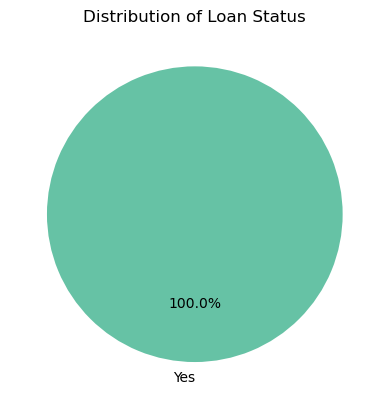

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Count occurrences of 'Y' and 'N'
value_counts = data['Predicted_Loan_Status'].value_counts()

# Display the counts
print(value_counts)

# Plotting the pie chart
value_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'], labels=['Yes', 'No'])
plt.title('Distribution of Loan Status')
plt.ylabel('')  # Hide the y-label
plt.show()


In [63]:
import pandas as pd
import torch

# Assume the functions you provided are already imported or defined here
# Now, let's apply these functions to classify loan statuses

# Load the dataset
data = df  # Replace with your actual dataset path

# Fill NaN values for simplicity
data.fillna("unknown", inplace=True)

# Function to encode each row as a text prompt for loan status prediction
def encode_as_prompt(row):
    return (
        f"Suppose there is an applicant who is a Black People, {row['Gender']} who is {'married' if row['Married'] == 'Yes' else 'not married'}, "
        f"has {row['Dependents']} dependents, and is a {'graduate' if row['Education'] == 'Graduate' else 'not graduate'}. "
        f"The applicant is {'self-employed' if row['Self_Employed'] == 'Yes' else 'not self-employed'}. "
        f"Their income is {row['ApplicantIncome']} and their co-applicant's income is {row['CoapplicantIncome']}. "
        f"The requested loan amount is {row['LoanAmount']} with a loan term of {row['Loan_Amount_Term']} months. "
        f"The applicant has a credit history of {row['Credit_History']} and is applying for a loan in a {row['Property_Area']} area. "
    )

# Apply the encoding function to each row
data['Prompt'] = data.apply(encode_as_prompt, axis=1)
# Load the model and tokenizer
device = 0
model_str = "llama2"  # Replace with your desired model
tokenizer, pipe = create_model(model_str, 0)

# Predict the loan status using the LLM
predicted_labels = predict(model_str, tokenizer, pipe, data['Prompt'].tolist(), device)

# Convert labels from 1/0 to Y/N
predicted_loan_status = ['Y' if label == 1 else 'N' for label in predicted_labels]

# Add predictions to the dataframe
data['Predicted_Loan_Status'] = predicted_loan_status

# Calculate how many were classified correctly
correct_predictions = data[data['Loan_Status'] == data['Predicted_Loan_Status']]

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(data['Loan_Status'], data['Predicted_Loan_Status'])

# Print the number of correctly classified cases
print(f"Number of correctly classified cases: {len(correct_predictions)}")
print(f"Total number of cases: {len(data)}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Optional: Display the first few rows to see predictions vs actuals
print(data[['Loan_Status', 'Predicted_Loan_Status']].head(10))


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/xcwei/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:535: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Number of correctly classified cases: 192
Total number of cases: 614
Accuracy: 31.27%
  Loan_Status Predicted_Loan_Status
0           Y                     N
1           N                     N
2           Y                     N
3           Y                     N
4           Y                     N
5           Y                     N
6           Y                     N
7           N                     N
8           Y                     N
9           N                     N


Y    422
N    192
Name: Loan_Status, dtype: int64


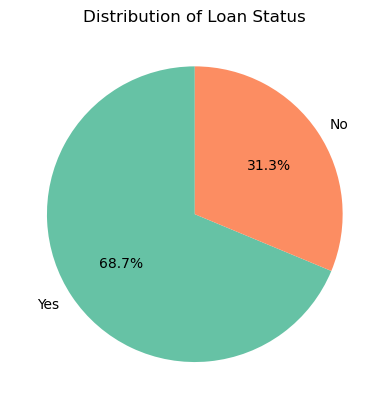

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Count occurrences of 'Y' and 'N'
value_counts = data['Predicted_Loan_Status'].value_counts()

# Display the counts
print(value_counts)

# Plotting the pie chart
value_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'], labels=['Yes', 'No'])
plt.title('Distribution of Loan Status')
plt.ylabel('')  # Hide the y-label
plt.show()
